In [1]:
import os, sys
from tqdm import trange

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import torch
from torch import nn
from torch.utils.data import TensorDataset, ConcatDataset

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
    PointAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation
from data_analysis.visualization.publication import pub_show

from model import MLP, CNN

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

device = torch.device("cpu")

GPU available


In [2]:
## Generate data
input_dim, output_dim = 1, 1

dy2 = 0
inputs = np.array([[-1] + [0] * (input_dim - 1), [1] + [0] * (input_dim - 1)])
outputs = np.array(
    [[0.6] + [0] * (output_dim - 1), [0.6 + np.sqrt(dy2 / 2)] + [0] * (output_dim - 1)]
)
names = ["A", "B"]
data = TensorDataset(
    torch.from_numpy(inputs.astype(np.float32)).to(device),
    torch.from_numpy(outputs.astype(np.float32)).to(device),
)

encoding = Encoding(dict(zip(names, inputs)))

train_datasets = [data]
val_dataset = [data]

tracked_datasets = val_dataset + train_datasets

In [3]:
gain = 3
P = 50
L = 10

In [4]:
## Instantiate model
model = CNN(
    encoding=encoding,
    input_size=inputs.shape[1],
    output_size=outputs.shape[1],
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
    non_linearity=torch.nn.functional.leaky_relu,
)

In [5]:
## Setup compiler

# Define hyperparameters
lr = 0.1 * output_dim / P

# Define Loss, Optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model, lambda inputs: model(inputs)[1][int(len(model) / 2)]
    ),
    "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
}

In [6]:
## Training run
compiler.training_run(train_datasets, tracked_datasets, n_epochs=500, batch_size=100)

Training: 100%|██████████| 500/500 [00:05<00:00, 85.43steps/s, train_loss=0.00659, val_loss=0.00659]


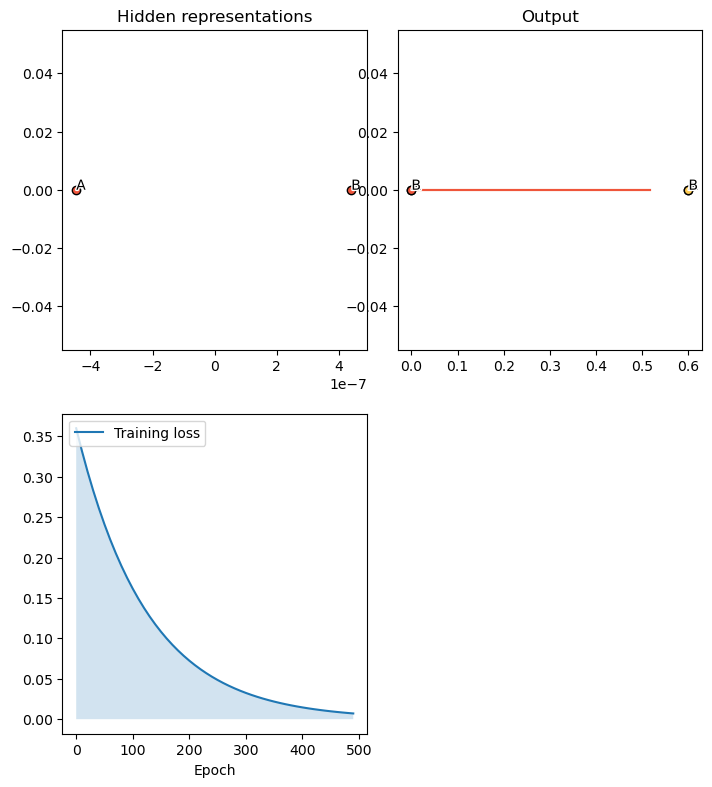

interactive(children=(SelectionSlider(description='Epoch:', options=(0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 10…

In [7]:
## Visualize representation dynamics
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "Epoch % 10 == 0"
data_hid = data_hid.copy().query(query)
data_output = data_output.copy().query(query)

loss = compiler.trackers["loss"].get_trace().copy()
val_loss = loss.query(query).query("Dataset==0")[0].to_numpy()
train_loss = loss.groupby("Epoch").mean().query(query)

epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()


animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(
            data_hid.query("Dataset != 0"), transform="PCA", plot_labels=True
        ),
        "Output": ActivationsAnimation(
            data_output.query("Dataset != 0"),
            transform="none",
            plot_labels=True,
            fixed_points=dict(zip(names, outputs)),
        ),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                # "Validation loss": val_loss,
            },
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

In [8]:
name = "animation"
# animation.to_gif("plots/" + name)

In [9]:
h_A = [
    np.array(data.loc[epoch, 0, "A"])
    for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
]
h_B = [
    np.array(data.loc[epoch, 0, "B"])
    for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
]
y_A = [
    np.array(data.loc[epoch, 0, "A"])
    for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
]
y_B = [
    np.array(data.loc[epoch, 0, "B"])
    for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
]

epochs = np.arange(0, len(h_A))
y_true_A, y_true_B = outputs[0], outputs[1]
dy2 = np.sum((y_true_B - y_true_A) ** 2)
h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])
y = [y_B[epoch] - y_A[epoch] - (y_true_B - y_true_A) for epoch in epochs]
y2 = np.array([np.sum((y[epoch]) ** 2) for epoch in epochs])
w = np.array([y2[epoch] + np.dot(y_true_B - y_true_A, y[epoch]) for epoch in epochs])

h0, y0, w0, dy = h2[0], y2[0], w[0], dy2
print(f"h0: {h0}")
print(f"y0: {y0}")
print(f"w0: {w0}")
print(f"dy: {dy}")
print(f"D02: {((y_B[0] - y_A[0])/h0)[0]}")  # Not sure correct because of squares in y

h0: 7.818174818478851e-13
y0: 2.2722697680362002e-27
w0: 2.2722697680362002e-27
dy: 0.0
D02: 0.06097117438912392


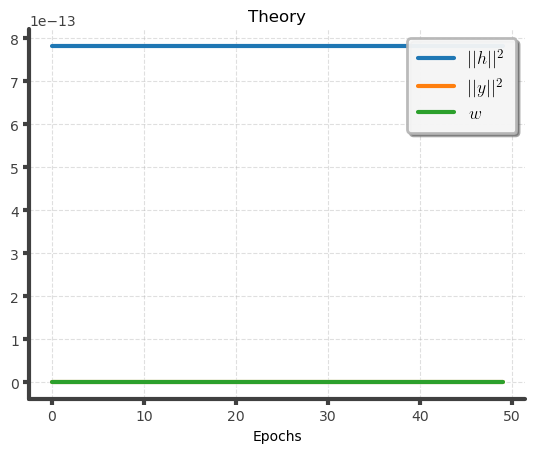

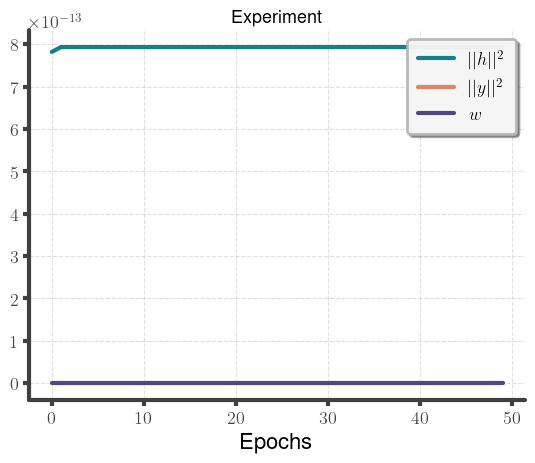

In [10]:
## Comparison
eta_h = lr * 100
eta_y = eta_h * 1

fun = lambda h: 1


def der(t, z):
    h, y, w = z
    return [
        -eta_h * w,
        -(eta_y * fun(h) * y + eta_h * w**2 / h),
        0.5 * (eta_y * fun(h) * (-w - y) - eta_h * (w / h) * (3 * w - y + dy)),
    ]


t_max = len(epochs)

sol = scipy.integrate.solve_ivp(der, [0, t_max], [h0, y0, w0], dense_output=True)

t = np.linspace(0, t_max, len(epochs))
z = sol.sol(t)


fig, ax = plt.subplots()
plt.plot(epochs, z[0], label="$||h||^2$")
plt.plot(epochs, z[1], label="$||y||^2$")
plt.plot(epochs, z[2], label="$w$")
ax.legend()
plt.xlabel("Epochs")
plt.title("Theory")
# plt.show()
pub_show()

fig, ax = plt.subplots()
# plt.plot(epochs, z[0], linestyle="--")
# plt.plot(epochs, z[1], linestyle="--")
# plt.plot(epochs, z[2], linestyle="--")
plt.gca().set_prop_cycle(None)
ax.plot(epochs, h2, label="$||h||^2$")
ax.plot(epochs, y2, label="$||y||^2$")
ax.plot(epochs, w, label="$w$")
ax.legend()
plt.xlabel("Epochs")
plt.title("Experiment")
# plt.show()
pub_show()

/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/torch/_functorch/deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

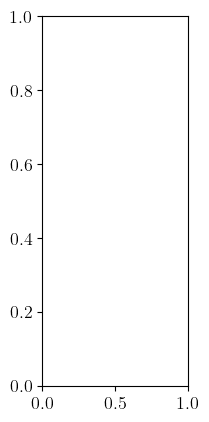

In [11]:
from functorch import make_functional, vmap, vjp, jvp, jacrev

net = model.to(device)
fnet, params = make_functional(net)


def fnet_hidden(params, x):
    return fnet(params, x.unsqueeze(0))[1][int(L / 2)].squeeze(0)


def fnet_output(params, h):
    return fnet(params, h.unsqueeze(0))[0].squeeze(0)


x_1 = train_datasets[0][0][0]
x_2 = train_datasets[0][1][0]
h_1 = fnet_hidden(params, x_1)
h_2 = fnet_hidden(params, x_2)


def empirical_ntk(fnet_single, params, x1, x2):
    # Compute J(x1)
    jac1 = torch.vmap(jacrev(fnet_single), (None, 0))(params, x1)
    jac1 = [j.flatten(2) for j in jac1]

    # Compute J(x2)
    jac2 = torch.vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = [j.flatten(2) for j in jac2]

    # Compute J(x1) @ J(x2).T
    result = torch.stack(
        [torch.einsum("Naf,Mbf->NMab", j1, j2) for j1, j2 in zip(jac1, jac2)]
    )
    result = result.sum(0)
    return result


# Plot eNTK
fig = plt.figure()

plt.subplot(1, 3, 1)
result = empirical_ntk(fnet_hidden, params, x_1, x_1)
plt.imshow(result[0][0].detach().numpy())

plt.subplot(1, 3, 2)
result = empirical_ntk(fnet_hidden, params, x_2, x_2)
plt.imshow(result[0][0].detach().numpy())

plt.subplot(1, 3, 3)
result = empirical_ntk(fnet_hidden, params, x_1, x_2)
plt.imshow(result[0][0].detach().numpy())

plt.show()